In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import _harmonization_utils 
from calitp_data_analysis.sql import to_snakecase
from calitp_data_analysis import utils

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_268/3899940571.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  im

In [2]:
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

In [3]:
url_pt1 = "https://odpsvcs.dot.ca.gov/arcgis/rest/services/RCA/RCA_Projects_032022/FeatureServer/"
url_pt2 = "/query?where=1%3D1&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&distance=&units=esriSRUnit_Foot&relationParam=&outFields=*+&returnGeometry=true&maxAllowableOffset=&geometryPrecision=&outSR=&gdbVersion=&historicMoment=&returnDistinctValues=false&returnIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&returnZ=false&returnM=false&multipatchOption=&resultOffset=&resultRecordCount=&returnTrueCurves=false&sqlFormat=none&f=geojson"

In [4]:
def sb1_basic_cleaning(
    df,
    agency_col: str,
    project_name_col: str,
    project_id_col: str,
    project_desc_col: str,
):
    """
    Perform basic cleaning before joining
    SB1 & Non SHOPP data together.
    """
    # Remove all punctation, lowercase, and strip whitespaces from
    # project titles & descriptions.
    for i in [project_name_col, project_desc_col]:
        df[i] = df[i].str.lower().str.replace("[^\w\s]", "").str.strip()

    # Some project names contain the year. Remove anything after 20..
    df[project_name_col] = df[project_name_col].str.split("20").str[0]

    # Get rid of | in object cols
    # https://stackoverflow.com/questions/68152902/extracting-only-object-type-columns-in-a-separate-list-from-a-data-frame-in-pand
    string_cols = df.select_dtypes(include=["object"]).columns.to_list()
    try:
        for i in string_cols:
            df[i] = df[i].str.replace("|", "")
    except:
        pass

    # Try to extract titles from popups
    try:
        df["popup"] = (
            df["popup"]
            .str.split("<br  />")
            .str[1]
            .str.split("20")
            .str[0]
            .str.lower()
            .str.strip()
            .str.replace("[^\w\s]", "")
        )
    except:
        pass

    return df

In [5]:
def load_sb1_rest_server() -> gpd.GeoDataFrame:
    """
    Load all the projects on the SB1
    map from the Feature Server.

    https://odpsvcs.dot.ca.gov/arcgis/rest/services/RCA/RCA_Projects_032022/FeatureServer
    """
    full_gdf = pd.DataFrame()
    for i in [*range(0, 22)]:
        df = to_snakecase(gpd.read_file(f"{url_pt1}{i}{url_pt2}"))
        full_gdf = pd.concat([full_gdf, df], axis=0)

    # Basic cleaning
    full_gdf = sb1_basic_cleaning(
        full_gdf, "agencies", "projecttitle", "projectid", "projectdescription"
    )

    # Fill in project titles that are empty with information
    # gleaned from the pop up.
    full_gdf["projecttitle"] = full_gdf["projecttitle"].fillna(full_gdf["popup"])

    # Throw out missing geometry
    missing_geo = full_gdf[full_gdf.geometry.is_empty]
    full_gdf = full_gdf[~full_gdf.geometry.is_empty].reset_index(drop=True)

    return full_gdf, missing_geo

In [6]:
# sb1, missing_geo_sb1 = load_sb1_rest_server()

In [7]:
# len(sb1), type(sb1)

In [8]:
# len(missing_geo_sb1)

In [9]:
def load_sb1_all_projects() -> pd.DataFrame:
    """
    Load in all projects layer of SB1 because it
    contains a value for every row in the
    project title column.
    """
    df = f"{url_pt1}22{url_pt2}"

    df = to_snakecase(gpd.read_file(df))

    # No geometry, just drop it
    df = df.drop(columns=["geometry"])

    # Basic cleaning
    df = sb1_basic_cleaning(
        df, "implementingagency", "projecttitle", "projectid", "projectdescription"
    )

    return df

In [10]:
# sb1_all_projects = load_sb1_all_projects()

In [11]:
# len(sb1_all_projects)

In [12]:
def sb1_final() -> gpd.GeoDataFrame:
    """
    Layers 0-21 with geographic information
    don't always have project titles for each
    of the projects. Merge these layers with
    layer 22, which does have title information.
    """
    all_projects_subset = [
        "projecttitle",
        "programcodes",
        "totalcost",
        "implementingagency",
        "fiscalyearcode",
    ]

    sb1_geo, missing_geo = load_sb1_rest_server()
    sb1_all_projects = load_sb1_all_projects()[all_projects_subset]

    # Merge
    merge1 = pd.merge(
        sb1_geo,
        sb1_all_projects,
        how="left",
        left_on=["programcodes", "totalcost", "agencies", "fiscalyearcodes"],
        right_on=["programcodes", "totalcost", "implementingagency", "fiscalyearcode"],
    )

    # Fill in missing project titles in sb1_geo with information from
    # sb1_all_projects
    merge1.projecttitle_x = merge1.projecttitle_x.fillna(merge1.projecttitle_y)

    # Fill missing titles with none
    merge1.projecttitle_x = merge1.projecttitle_x.fillna("None")
    
    # Drop columns
    merge1 = merge1.drop(columns = ['projecttitle_y'])
    
    # Add a new column detailing where this information comes from 
    merge1 = merge1.assign(
        notes = merge1.programcodes + '/' + 'SB1')
    
    merge1 = merge1.fillna(merge1.dtypes.replace({'float64': 0.0, 'object': 'None'}))
    return merge1

In [13]:
sb1_final_gdf = sb1_final()

/tmp/ipykernel_268/750967614.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
/tmp/ipykernel_268/750967614.py:25: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
/tmp/ipykernel_268/750967614.py:32: FutureWarning: The default value of regex will change from True to False in a future version.
/tmp/ipykernel_268/750967614.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
/tmp/ipykernel_268/750967614.py:25: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [14]:
sb1_final_gdf.projectstatuscodes.value_counts()

Completed                     2854
InProgress                    1356
Planned                       1342
CompletedInProgress            231
CompletedInProgressPlanned     154
CompletedPlanned               128
InProgressPlanned               72
In Progress                     22
Name: projectstatuscodes, dtype: int64

In [15]:
len(sb1_final_gdf), sb1_final_gdf.geometry.nunique()

(6159, 5503)

In [16]:
sb1_final_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 6159 entries, 0 to 6158
Data columns (total 41 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   objectid                6159 non-null   int64   
 1   agencyids               6159 non-null   object  
 2   agencies                6159 non-null   object  
 3   programcodes            6159 non-null   object  
 4   iijaprogram             6159 non-null   object  
 5   iijacodes               6159 non-null   object  
 6   projectstatuscodes      6159 non-null   object  
 7   fiscalyears             6159 non-null   object  
 8   fiscalyearcodes         6159 non-null   object  
 9   projectstatuses         6159 non-null   object  
 10  sb1funds                6159 non-null   float64 
 11  iijafunds               6159 non-null   float64 
 12  totalcost               6159 non-null   float64 
 13  dateupdated             6159 non-null   object  
 14  projectcount    

In [26]:
sb1_final_gdf.projecttitle_x.value_counts().head(10)

None                                                      881
major damage restoration                                  470
safety improvements                                       369
pavement rehabilitation                                   307
pavement  hm1                                             267
safety  hm4                                               176
permanent restoration                                     151
drainage  hm251                                           146
drainage system restoration                               141
roadside safety improvementsfreeway maintenance access    140
Name: projecttitle_x, dtype: int64

In [30]:
sb1_final_gdf[sb1_final_gdf.projecttitle_x == "major damage restoration"].groupby(['projecttitle_x', 'countynames']).agg({'objectid':'count'}).head()

objectid
projecttitle_x           countynames                    
major damage restoration                               1
                         Alameda                      15
                         Alameda, Contra Costa         2
                         Alameda, Santa Clara          1
                         Alpine                        1

In [34]:
sb1_final_gdf.projectstatuscodes.value_counts()

Completed                     2854
InProgress                    1356
Planned                       1342
CompletedInProgress            231
CompletedInProgressPlanned     154
CompletedPlanned               128
InProgressPlanned               72
In Progress                     22
Name: projectstatuscodes, dtype: int64

In [36]:
sb1_final_gdf.projectstatuscodes.unique()

array(['Completed', 'Planned', 'InProgressPlanned',
       'CompletedInProgressPlanned', 'InProgress', 'In Progress',
       'CompletedPlanned', 'CompletedInProgress'], dtype=object)

In [35]:
sb1_final_gdf.projectstatuses.value_counts()

Completed                                      2854
In Progress                                    1348
Planned                                        1342
Completed, Planned                              128
Completed, InProgress                           115
Completed, In Progress                          112
Completed, In Progress, Planned                  87
In Progress, Planned                             61
Completed, InProgress, Planned                   61
InProgress                                       30
InProgress, Planned                              11
Completed, In Progress, InProgress, Planned       4
Completed, In Progress, InProgress                4
Completed, In Progress, P                         2
Name: projectstatuses, dtype: int64

In [29]:
sb1_final_gdf[(sb1_final_gdf.projecttitle_x == "major damage restoration") & (sb1_final_gdf.countynames == "Alameda")]

,objectid,agencyids,agencies,programcodes,iijaprogram,iijacodes,projectstatuscodes,fiscalyears,fiscalyearcodes,projectstatuses,sb1funds,iijafunds,totalcost,dateupdated,projectcount,assemblydistricts,senatedistricts,congressionaldistricts,assemblycodes,senatecodes,congressionalcodes,countynames,citynames,countycodes,citycodes,ct_codes,ct_districts,issb1,isiija,isonshs,issb1codes,isiijacode,isonshscodes,popup,geometry,projectid,projecttitle_x,projectdescription,implementingagency,fiscalyearcode,notes
2561,7896,0000,Caltrans,SHOPP,None,None,Completed,19/20,1920,Completed,0.00,0.00,1791642.18,2022-06-28,1,18,09,13,18,09,13,Alameda,"Alameda, Oakland",ALA,ALAOAK,04,04,None,N,None,N,N,Y,major damage restorationbr,MULTIPOINT (-122.25684 37.78980),0419000181,major damage restoration,a 179 million dollar project in alameda county on route 880 will replace failed expansion joints,Caltrans,1920,SHOPP/SB1
2566,7901,0000,Caltrans,SHOPP,None,None,Completed,19/20,1920,Completed,0.00,0.00,746554.65,2022-06-28,1,15,09,13,15,09,13,Alameda,Oakland,ALA,OAK,04,04,None,N,None,N,N,Y,major damage restorationbr,MULTIPOINT (-122.20822 37.82296),0419000307,major damage restoration,a 075 million dollar project in alameda county on route 13 will repair slope and drainage system,Caltrans,1920,SHOPP/SB1
2571,7906,0000,Caltrans,SHOPP,None,None,InProgress,18/19,1819,In Progress,0.00,0.00,23050000.00,2022-06-28,1,"16, 20",07,15,1620,07,15,Alameda,Pleasanton,ALA,PLE,04,04,None,N,None,N,N,Y,major damage restorationbr,MULTIPOINT (-121.81288 37.61693),0419000370,major damage restoration,a 2305 million dollar project in alameda county on route 84 will stabilize slope and repair drainage system,Caltrans,1819,SHOPP/SB1
2579,7914,0000,Caltrans,SHOPP,None,None,Completed,20/21,2021,Completed,0.00,0.00,1464217.15,2022-06-28,1,18,09,13,18,09,13,Alameda,Oakland,ALA,OAK,04,04,None,N,None,N,N,Y,major damage restorationbr,MULTIPOINT (-122.23179 37.77458),0420000023,major damage restoration,a 146 million dollar project in alameda county on route 880 will remediate soil vapor containing constituents of concern,Caltrans,2021,SHOPP/SB1
2584,7919,0000,Caltrans,SHOPP,None,None,Completed,21/22,2122,Completed,0.00,0.00,1979823.63,2022-06-28,1,15,09,13,15,09,13,Alameda,"Berkeley, Oakland",ALA,BEROAK,04,04,None,N,None,N,N,Y,major damage restorationbr,MULTIPOINT (-122.23247 37.85079),0420000096,major damage restoration,a 198 million dollar project in alameda county on route var will provide portable generators at signals traffic control and detours during highwind public safety power shutoff outages,Caltrans,2122,SHOPP/SB1
2594,7929,0000,Caltrans,SHOPP,None,None,Completed,20/21,2021,Completed,0.00,0.00,2132206.29,2022-06-28,1,20,10,15,20,10,15,Alameda,"Hayward, Union City",ALA,HAYUNC,04,04,None,N,None,N,N,Y,major damage restorationbr,MULTIPOINT (-122.07418 37.61757),0420000347,major damage restoration,a 213 million dollar project in alameda county on route 880 will repair bridge by replacing exterior girder adjoining deck and barrier rail and install advanced warning signs,Caltrans,2021,SHOPP/SB1
2596,7931,0000,Caltrans,SHOPP,None,None,Completed,20/21,2021,Completed,0.00,0.00,362565.10,2022-06-28,1,18,09,13,18,09,13,Alameda,"Alameda, Oakland",ALA,ALAOAK,04,04,None,N,None,N,N,Y,major damage restorationbr,MULTIPOINT (-122.24475 37.78605),0421000014,major damage restoration,a 036 million dollar project in alameda county on route 880 will repair spalled surfaces on the soffit secure soffit access and clear out the burned material,Caltrans,2021,SHOPP/SB1
2598,7933,0000,Caltrans,SHOPP,None,None,Completed,21/22,2122,Completed,0.00,0.00,1017344.01,2022-06-28,1,"15, 18",09,13,1518,09,13,Alameda,Oakland,ALA,OAK,04,04,None,N,None,N,N,Y,major damage restorationbr,MULTIPOINT (-122.25525 37.82007),0421000047,major damage restoration,a 102 million dollar project in alameda county on route 580 will construct wrought iron fencing with secured access gates,Caltrans,2122,SHOPP/SB1
2610,7945,0000,Caltrans,S

<AxesSubplot:>

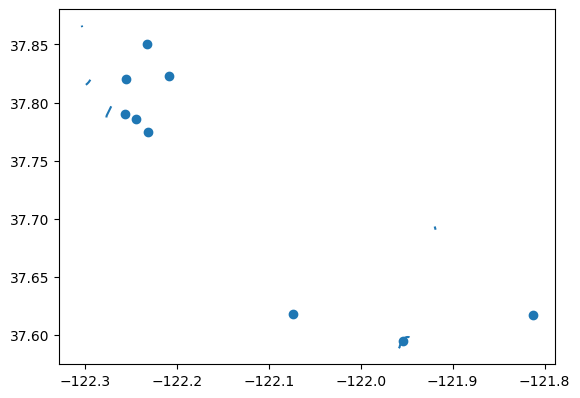

In [31]:
sb1_final_gdf[(sb1_final_gdf.projecttitle_x == "major damage restoration") & (sb1_final_gdf.countynames == "Alameda")].plot()

In [32]:
# sb1_final_gdf[sb1_final_gdf.projecttitle_x == "major damage restoration"].explore()